In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [1]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/dhruvjignesh.shah001/anaconda3/envs/O/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 5.0.1
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: 2.8.0
gdown version: 4.6.3
TorchVision version: 0.14.1+cu117
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.1
pandas version: 1.2.3
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
pip install 'monai[all]'

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install 'monai[einops]'

Note: you may need to restart the kernel to use updated packages.


In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp_53g5kwo


In [3]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):

    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

In [5]:
def get_loader(batch_size, data_dir, json_list, fold, roi):
    data_dir = data_dir
    datalist_json = json_list
    train_files, validation_files = datafold_read(datalist=datalist_json, basedir=data_dir, fold=fold)
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)

    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )

    return train_loader, val_loader

In [5]:
#import json

In [6]:
#label_dir = "research-contributions/BraTS2021_00495"
#labelNames = os.listdir(label_dir)
#labelNames

['BraTS2021_00495_t1.nii.gz',
 'BraTS2021_00495_t1ce.nii.gz',
 'BraTS2021_00495_flair.nii.gz',
 'BraTS2021_00495_t2.nii.gz',
 'BraTS2021_00495_seg.nii.gz']

In [41]:
#img_dir = "research-contributions/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021"
#imgNames = os.listdir(img_dir)
#imgNames

['img0035.nii.gz',
 'img0023.nii.gz',
 'img0038.nii.gz',
 'img0002.nii.gz',
 'img0037.nii.gz',
 'img0021.nii.gz',
 'img0040.nii.gz',
 'img0027.nii.gz',
 'img0031.nii.gz',
 'img0006.nii.gz',
 'img0010.nii.gz',
 'img0025.nii.gz',
 'img0028.nii.gz',
 'img0033.nii.gz',
 'img0004.nii.gz',
 'img0009.nii.gz',
 'img0007.nii.gz',
 'img0030.nii.gz',
 'img0026.nii.gz',
 'img0008.nii.gz',
 'img0005.nii.gz',
 'img0029.nii.gz',
 'img0032.nii.gz',
 'img0024.nii.gz',
 'img0003.nii.gz',
 'img0022.nii.gz',
 'img0039.nii.gz',
 'img0034.nii.gz',
 'img0001.nii.gz',
 'img0036.nii.gz']

In [47]:
#len(labelNames)

30

In [55]:
#imgNames[30]

IndexError: list index out of range

In [64]:
#for i in imgNames:
 #   print(i)

img0035.nii.gz
img0023.nii.gz
img0038.nii.gz
img0002.nii.gz
img0037.nii.gz
img0021.nii.gz
img0040.nii.gz
img0027.nii.gz
img0031.nii.gz
img0006.nii.gz
img0010.nii.gz
img0025.nii.gz
img0028.nii.gz
img0033.nii.gz
img0004.nii.gz
img0009.nii.gz
img0007.nii.gz
img0030.nii.gz
img0026.nii.gz
img0008.nii.gz
img0005.nii.gz
img0029.nii.gz
img0032.nii.gz
img0024.nii.gz
img0003.nii.gz
img0022.nii.gz
img0039.nii.gz
img0034.nii.gz
img0001.nii.gz
img0036.nii.gz


In [74]:
#dic = {}

In [83]:
#dic = {"image": imgNames[0], "label": labelNames[0]}

In [96]:
#for i in range(30):
 #   dic_lst = [{"image":imgNames[i], "label":labelNames[i]}]

In [97]:
#for i in range(29):
 #   dic_lst.append({"image":imgNames[i], "label":labelNames[i]})

In [85]:
#for i,j in zip(imgNames, labelNames):
 #   dic = [{"image": i, "label": j}]

In [19]:
#for i in allFileNames:
    

In [98]:
#print(dic_lst)

[{'image': 'img0036.nii.gz', 'label': 'label0036.nii.gz'}, {'image': 'img0035.nii.gz', 'label': 'label0035.nii.gz'}, {'image': 'img0023.nii.gz', 'label': 'label0038.nii.gz'}, {'image': 'img0038.nii.gz', 'label': 'label0023.nii.gz'}, {'image': 'img0002.nii.gz', 'label': 'label0002.nii.gz'}, {'image': 'img0037.nii.gz', 'label': 'label0037.nii.gz'}, {'image': 'img0021.nii.gz', 'label': 'label0021.nii.gz'}, {'image': 'img0040.nii.gz', 'label': 'label0040.nii.gz'}, {'image': 'img0027.nii.gz', 'label': 'label0027.nii.gz'}, {'image': 'img0031.nii.gz', 'label': 'label0031.nii.gz'}, {'image': 'img0006.nii.gz', 'label': 'label0006.nii.gz'}, {'image': 'img0010.nii.gz', 'label': 'label0010.nii.gz'}, {'image': 'img0025.nii.gz', 'label': 'label0025.nii.gz'}, {'image': 'img0028.nii.gz', 'label': 'label0033.nii.gz'}, {'image': 'img0033.nii.gz', 'label': 'label0028.nii.gz'}, {'image': 'img0004.nii.gz', 'label': 'label0004.nii.gz'}, {'image': 'img0009.nii.gz', 'label': 'label0009.nii.gz'}, {'image': 'im

In [99]:
#json_object = json.dumps(dic_lst, indent = 4)

In [100]:
#with open("sample1.json", "w") as outfile:
 #   outfile.write(json_object)

In [6]:
data_dir = "research-contributions/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021"
json_list = "research-contributions/brats21_folds.json"
roi = (128, 128, 128)
batch_size = 2
sw_batch_size = 4
fold = 1
infer_overlap = 0.5
max_epochs = 20 #changing it to 20, just for initial checking
val_every = 10
train_loader, val_loader = get_loader(batch_size, data_dir, json_list, fold, roi)

This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

In [8]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

In [9]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()
    start_time = time.time()
    run_loss = AverageMeter()
    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=batch_size)
        print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            "loss: {:.4f}".format(run_loss.avg),
            "time {:.2f}s".format(time.time() - start_time),
        )
        start_time = time.time()
    return run_loss.avg


def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    model.eval()
    start_time = time.time()
    run_acc = AverageMeter()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            dice_tc = run_acc.avg[0]
            dice_wt = run_acc.avg[1]
            dice_et = run_acc.avg[2]
            print(
                "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", time {:.2f}s".format(time.time() - start_time),
            )
            start_time = time.time()

    return run_acc.avg

In [10]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):

    val_acc_max = 0.0
    dices_tc = []
    dices_wt = []
    dices_et = []
    dices_avg = []
    loss_epochs = []
    trains_epoch = []
    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "loss: {:.4f}".format(train_loss),
            "time {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            dice_tc = val_acc[0]
            dice_wt = val_acc[1]
            dice_et = val_acc[2]
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", Dice_Avg:",
                val_avg_acc,
                ", time {:.2f}s".format(time.time() - epoch_time),
            )
            dices_tc.append(dice_tc)
            dices_wt.append(dice_wt)
            dices_et.append(dice_et)
            dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    best_acc=val_acc_max,
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        dices_tc,
        dices_wt,
        dices_et,
        dices_avg,
        loss_epochs,
        trains_epoch,
    )

In [11]:
start_epoch = 0

(val_acc_max, dices_tc, dices_wt, dices_et, dices_avg, loss_epochs, trains_epoch,) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

Tue Feb 14 01:23:09 2023 Epoch: 0
Epoch 0/20 0/501 loss: 0.9818 time 48.33s
Epoch 0/20 1/501 loss: 0.9905 time 0.83s
Epoch 0/20 2/501 loss: 0.9781 time 0.83s
Epoch 0/20 3/501 loss: 0.9782 time 0.83s
Epoch 0/20 4/501 loss: 0.9750 time 0.89s
Epoch 0/20 5/501 loss: 0.9753 time 0.95s
Epoch 0/20 6/501 loss: 0.9644 time 1.01s
Epoch 0/20 7/501 loss: 0.9553 time 1.08s
Epoch 0/20 8/501 loss: 0.9524 time 1.16s
Epoch 0/20 9/501 loss: 0.9507 time 1.14s
Epoch 0/20 10/501 loss: 0.9485 time 1.43s
Epoch 0/20 11/501 loss: 0.9496 time 1.12s
Epoch 0/20 12/501 loss: 0.9513 time 1.12s
Epoch 0/20 13/501 loss: 0.9547 time 1.12s
Epoch 0/20 14/501 loss: 0.9576 time 1.18s
Epoch 0/20 15/501 loss: 0.9593 time 1.12s
Epoch 0/20 16/501 loss: 0.9588 time 1.13s
Epoch 0/20 17/501 loss: 0.9597 time 1.18s
Epoch 0/20 18/501 loss: 0.9586 time 1.11s
Epoch 0/20 19/501 loss: 0.9565 time 1.26s
Epoch 0/20 20/501 loss: 0.9559 time 2.80s
Epoch 0/20 21/501 loss: 0.9531 time 1.16s
Epoch 0/20 22/501 loss: 0.9546 time 1.15s
Epoch 0/2

None of the inputs have requires_grad=True. Gradients will be None


Val 0/20 0/250 , dice_tc: 0.1329258 , dice_wt: 0.71029264 , dice_et: 0.09169761 , time 24.17s
Val 0/20 1/250 , dice_tc: 0.40379888 , dice_wt: 0.79530734 , dice_et: 0.22133021 , time 1.94s
Val 0/20 2/250 , dice_tc: 0.3632392 , dice_wt: 0.7078311 , dice_et: 0.20865099 , time 1.92s
Val 0/20 3/250 , dice_tc: 0.42886236 , dice_wt: 0.69926375 , dice_et: 0.26870573 , time 1.91s
Val 0/20 4/250 , dice_tc: 0.35329142 , dice_wt: 0.5767225 , dice_et: 0.22454286 , time 1.95s
Val 0/20 5/250 , dice_tc: 0.37752584 , dice_wt: 0.60523516 , dice_et: 0.24096923 , time 1.94s
Val 0/20 6/250 , dice_tc: 0.3255903 , dice_wt: 0.5362159 , dice_et: 0.20806897 , time 1.94s
Val 0/20 7/250 , dice_tc: 0.28994533 , dice_wt: 0.5251375 , dice_et: 0.18676655 , time 1.96s
Val 0/20 8/250 , dice_tc: 0.33540404 , dice_wt: 0.54821604 , dice_et: 0.24273801 , time 1.95s
Val 0/20 9/250 , dice_tc: 0.31280002 , dice_wt: 0.56764644 , dice_et: 0.22777383 , time 1.93s
Val 0/20 10/250 , dice_tc: 0.32151362 , dice_wt: 0.5635035 , dice_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
print(f"train completed, best average dice: {val_acc_max:.4f} ")

train completed, best average dice: 0.7870 


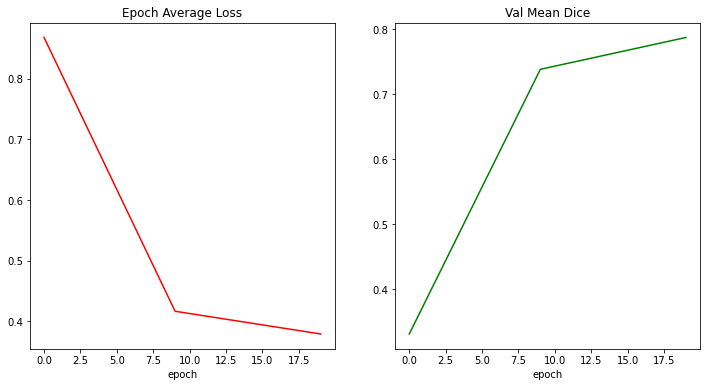

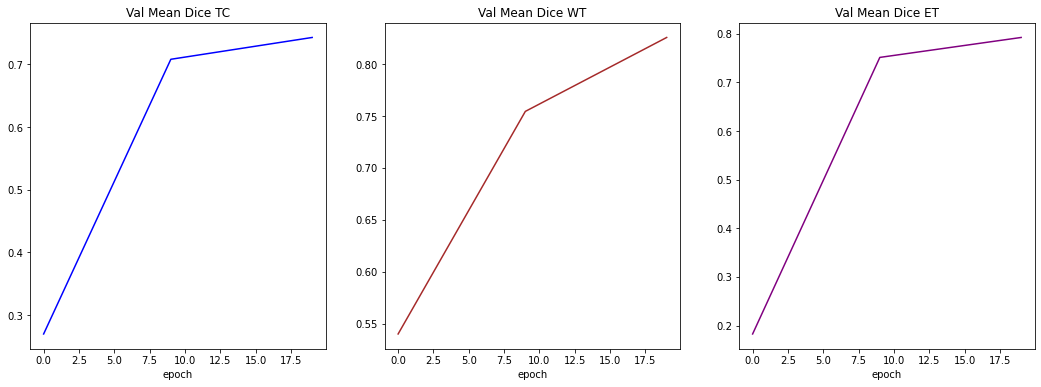

In [13]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(trains_epoch, loss_epochs, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_avg, color="green")
plt.show()
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_tc, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_wt, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_et, color="purple")
plt.show()

In [15]:
case_num = "01619"

test_files = [
    {
        "image": [
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_flair.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t2.nii.gz",
            ),
        ],
        "label": os.path.join(
            data_dir,
            "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
        ),
    }
]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

In [16]:
model.load_state_dict(torch.load(os.path.join(root_dir, "model.pt"))["state_dict"])
model.to(device)
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)


with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4

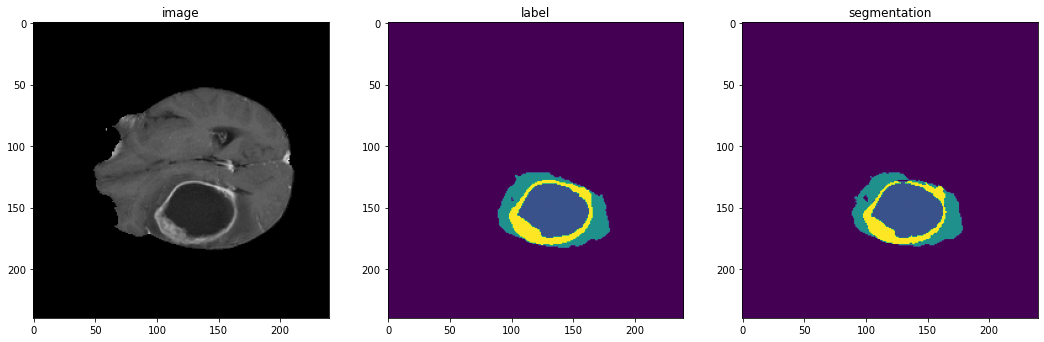

In [17]:
slice_num = 67
img_add = os.path.join(
    data_dir,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
)
label_add = os.path.join(
    data_dir,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()

In [1]:
import tensorflow as tf

2023-02-13 20:04:09.312880: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
gpu_available = tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-02-13 20:04:37.168169: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 20:04:37.170637: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-13 20:04:37.268972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-13 20:04:37.269017: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-13 20:04:37.305451: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] 

In [3]:
gpu_available

True

image shape: (512, 512, 147), label shape: (512, 512, 147)


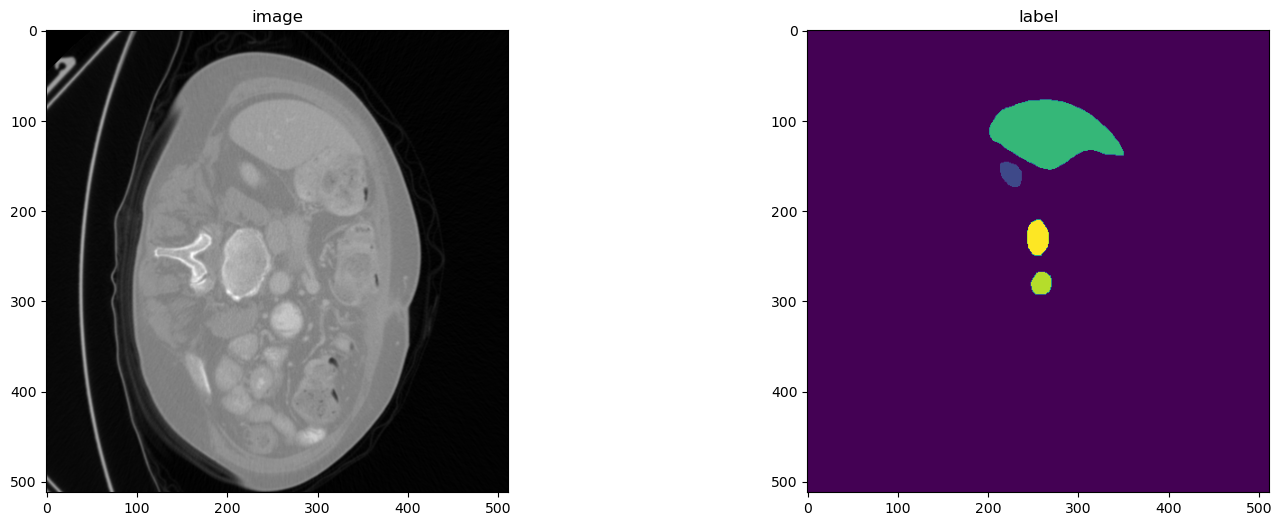

In [20]:
img_add = os.path.join(data_dir, "Training/img/img0001.nii.gz")
label_add = os.path.join(data_dir, "Training/label/label0001.nii.gz")
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, 78], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 78])
plt.show()